# **Data content - Forecasting**

In this file, there will be a demand forecasting system for a short-term period done.

There are 3 tables which will be considered. They include information as per below:

* **Order_items**: order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_val;
* **Orders**: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;
* **Products**: product_id, product_category_item, product_name_length, product_description_length, product_photos_qty, product_weight_g, produst_length_cm, product_height_cm, product_width_cm.

To prepare analysis, above data will be merged and based on this conclusions and observations will me made.

Primarily, each file will be considered separately, finally they will me merged.

# **Installation and imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

warnings.filterwarnings('ignore')

from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Analysis of Orders data**

In [ ]:
# Load orders data
orders = pd.read_csv("gdrive/My Drive/Task 1/orders.csv", parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [ ]:
# Shape of data
orders.shape

(99441, 8)

In [ ]:
# First 5 rows of data
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [ ]:
# Data types - 3 object and 5 datetime
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [ ]:
# Unique value in each column
print(orders.nunique())

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64


In [ ]:
# Check for duplicated rows - no duplicates
duplicate = orders[orders.duplicated()]
duplicate

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [ ]:
# Data info
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [ ]:
# Check for null values (null values occur for columns order_approved_at, order_delivered_carrier_date, order_delivered_customer_date - insignificant amount)
print(orders.isnull().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


In [ ]:
# Simplify the column names
orders.columns = (['order_id', 'customer_id', 'order_status', 'order_purchase', 'order_approved', 'order_carrier', 'order_customer', 'order_delivery'])

In [ ]:
# Reduce the memory thanks to changing the type of columns from object to categorical (order_status column)
orders['order_status'] = orders['order_status'].astype('category')

In [ ]:
# Check the info
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        99441 non-null  object        
 1   customer_id     99441 non-null  object        
 2   order_status    99441 non-null  category      
 3   order_purchase  99441 non-null  datetime64[ns]
 4   order_approved  99281 non-null  datetime64[ns]
 5   order_carrier   97658 non-null  datetime64[ns]
 6   order_customer  96476 non-null  datetime64[ns]
 7   order_delivery  99441 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), object(2)
memory usage: 5.4+ MB


In [ ]:
# Statistics for categorical data
print(orders.describe(include = 'category').T)

              count unique        top   freq
order_status  99441      8  delivered  96478


In [ ]:
# Replace null values in each column by 'No data'
orders = orders.replace(np.nan, 'No data')

In [ ]:
# Check for null values - they do not appear
print(orders.isnull().sum())

order_id          0
customer_id       0
order_status      0
order_purchase    0
order_approved    0
order_carrier     0
order_customer    0
order_delivery    0
dtype: int64


In [ ]:
# Unique values for order_status column
orders['order_status'].unique()

['delivered', 'invoiced', 'shipped', 'processing', 'unavailable', 'canceled', 'created', 'approved']
Categories (8, object): ['approved', 'canceled', 'created', 'delivered', 'invoiced', 'processing',
                         'shipped', 'unavailable']

In [ ]:
# Group by order_status column - the most orders have status delivered, the least - approved and created
occur = orders.groupby(['order_status'], as_index=False).size()
by_status = pd.DataFrame(occur)
print(by_status)

  order_status   size
0     approved      2
1     canceled    625
2      created      5
3    delivered  96478
4     invoiced    314
5   processing    301
6      shipped   1107
7  unavailable    609


# **Analysis of Order_items data**


In [ ]:
# Load items data and parse column with date
items = pd.read_csv("gdrive/My Drive/Task 1/order_items.csv", parse_dates=['shipping_limit_date'])

In [ ]:
# Shape of data
items.shape

(112650, 7)

In [ ]:
# First 5 rows of data
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
# Data types - 3 numerical, 3 object, 1 datetime
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [ ]:
# Unique value in each column
print(items.nunique())

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64


In [ ]:
# Check for duplicated rows - no duplicates
duplicate = items[items.duplicated()]
duplicate

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [ ]:
# Data info
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [ ]:
# Check for null values - no null values
print(items.isnull().sum())

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


# **Analysis of Products data**

In [ ]:
# Load products data
products = pd.read_csv("gdrive/My Drive/Task 1/products.csv")

In [ ]:
# Shape of data
products.shape

(32951, 9)

In [ ]:
# First 5 rows of data
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
# Data types - 7 numerical and 2 object
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [ ]:
# Unique value in each column
print(products.nunique())

product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64


In [ ]:
# Check for duplicated rows - no duplicates
duplicate = products[products.duplicated()]
duplicate

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [ ]:
# Data info
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
# Check for null values - no significant amount
print(products.isnull().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [ ]:
# Rows with missing values will be dropped
products = products.dropna(axis = 0)

In [ ]:
# Check if missing values still appear - they do not
print(products.isnull().sum())

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


In [ ]:
# Column product_category_name consist of non-English items.
# They will be translated thanks to additional table product_category_name_translation.
# Load category data
category = pd.read_csv("gdrive/My Drive/Task 1/product_category_name_translation.csv")
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
# Check for null values - no null values
print(category.isnull().sum())

product_category_name            0
product_category_name_english    0
dtype: int64


In [ ]:
# Merge product and category tables on product_category_name column
pro = pd.merge(products, category, on='product_category_name')
pro.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [ ]:
# Check for null values - no null values
print(pro.isnull().sum())

product_id                       0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64


In [ ]:
# Drop column with non-English product_category_name
pro.drop(['product_category_name'], axis=1, inplace=True)
pro.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [ ]:
# Simplify the column names
pro.columns = (['product_id', 'product_name_len', 'product_des_len', 'product_photos_qty', 'product_weight', 'product_length', 'product_height', 'product_width', 'product_name'])

# **Merge data into one DataFrame**

In [ ]:
# Merge tables with Order_items and Orders on order_id column
items_orders = pd.merge(items, orders, on='order_id', how='left')
items_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase,order_approved,order_carrier,order_customer,order_delivery
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [ ]:
# Shape of data
items_orders.shape

(112650, 14)

In [ ]:
# Check whether null values exist - no nulls
print(len(items_orders[items_orders.isna().any(axis=1)]))

0


In [ ]:
# Merge table Products with Items_orders on product_id column
df = pd.merge(items_orders, pro, on='product_id', how='left')
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase,...,order_customer,order_delivery,product_name_len,product_des_len,product_photos_qty,product_weight,product_length,product_height,product_width,product_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-20 23:43:48,2017-09-29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017-05-12 16:04:24,2017-05-15,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-01-22 13:19:16,2018-02-05,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-14 13:32:39,2018-08-20,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017-03-01 16:42:31,2017-03-17,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools


In [ ]:
# Shape of data
df.shape

(112650, 22)

In [ ]:
# Check wheather null values exist
print(len(df[df.isna().any(axis=1)]))

1628


In [ ]:
# Drop rows with missing values
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase,...,order_customer,order_delivery,product_name_len,product_des_len,product_photos_qty,product_weight,product_length,product_height,product_width,product_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-20 23:43:48,2017-09-29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017-05-12 16:04:24,2017-05-15,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-01-22 13:19:16,2018-02-05,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-14 13:32:39,2018-08-20,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017-03-01 16:42:31,2017-03-17,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools


In [ ]:
# Check whether null values exist - no nulls
print(len(df[df.isna().any(axis=1)]))

0


# **Data preparation**

In [ ]:
# Select columns for further analysis: product_id, order_purchase, product_name
data = df[['product_id', 'order_purchase', 'product_name']]
data.head()

,product_id,order_purchase,product_name
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,cool_stuff
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,pet_shop
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,furniture_decor
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,perfumery
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,garden_tools


In [ ]:
# Check the max date
max = data['order_purchase'].max()
max.date()

datetime.date(2018, 9, 3)

In [ ]:
# Create new column only with date
data['date'] = [d.date() for d in data['order_purchase']]

In [ ]:
# Check first 5 rows
data.head()

,product_id,order_purchase,product_name,date
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,cool_stuff,2017-09-13
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,pet_shop,2017-04-26
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,furniture_decor,2018-01-14
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,perfumery,2018-08-08
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,garden_tools,2017-02-04


In [ ]:
# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111022 entries, 0 to 111021
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   product_id      111022 non-null  object        
 1   order_purchase  111022 non-null  datetime64[ns]
 2   product_name    111022 non-null  object        
 3   date            111022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.4+ MB


In [ ]:
# Group data by date and count of orders at this date
group = data[['product_name']].groupby([data['date']]).agg(count=('product_name', 'count')).reset_index()
group

,date,count
0,2016-09-04,2
1,2016-09-05,1
2,2016-09-15,3
3,2016-10-02,1
4,2016-10-03,8
...,...,...
611,2018-08-26,81
612,2018-08-27,69
613,2018-08-28,45
614,2018-08-29,16


In [ ]:
# Set index of a series
indexed = group.set_index(['date'])
indexed.head()

,count
date,
2016-09-04,2
2016-09-05,1
2016-09-15,3
2016-10-02,1
2016-10-03,8


In [ ]:
# Fill missing indexes between min and max date
df = indexed.reindex(pd.date_range(group['date'].min(), group['date'].max(), freq ='D'))
df

,count
2016-09-04,2.0
2016-09-05,1.0
2016-09-06,NaN
2016-09-07,NaN
2016-09-08,NaN
...,...
2018-08-30,NaN
2018-08-31,NaN
2018-09-01,NaN
2018-09-02,NaN


In [ ]:
# There are only missing values in count column, they will be interpolated
df['count'].interpolate(method='linear', inplace=True)
df

,count
2016-09-04,2.0
2016-09-05,1.0
2016-09-06,1.2
2016-09-07,1.4
2016-09-08,1.6
...,...
2018-08-30,13.0
2018-08-31,10.0
2018-09-01,7.0
2018-09-02,4.0


In [ ]:
# Simple statistics
df.describe()

,count
count,730.000000
mean,154.521233
std,113.505581
min,1.000000
25%,69.500000
50%,148.000000
75%,228.000000
max,1353.000000


In [ ]:
# Percentiles
df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,count
count,730.000000
mean,154.521233
std,113.505581
min,1.000000
25%,69.500000
50%,148.000000
75%,228.000000
90%,297.100000
95%,333.550000
99%,421.000000


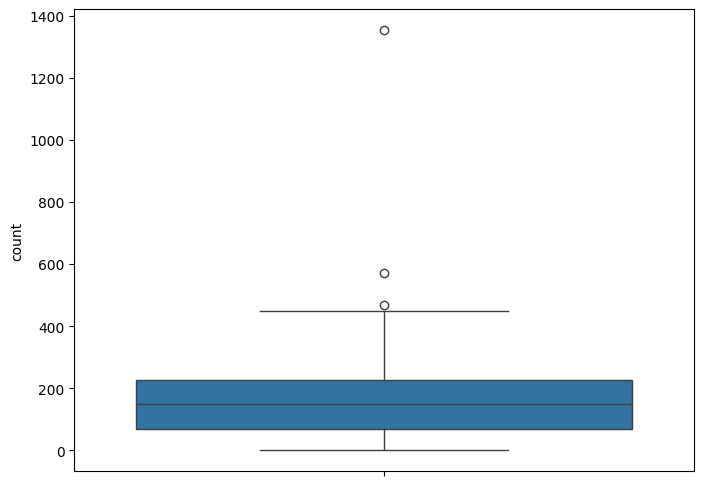

In [ ]:
# Check the outliers by boxplot - they exist, but they will be kept because deleting any data point will lead to discontuity in the data
plt.figure(figsize=(8,6))
sns.boxplot(df['count'])
plt.show()

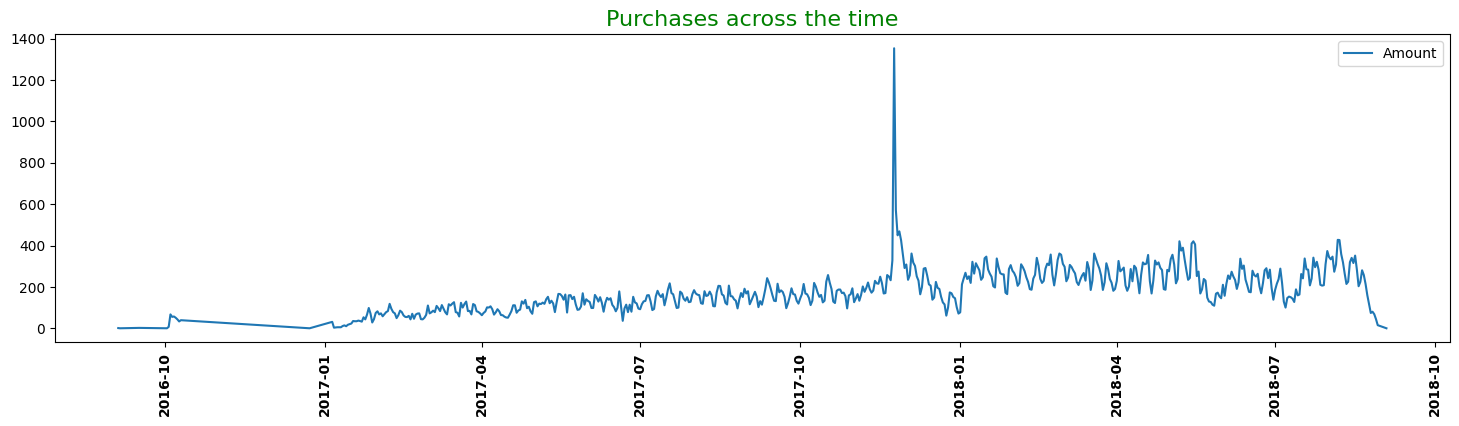

In [ ]:
# Plot with amount of purchases across the time - the amount was raising slowly with unpredictable peak in November/December 2018
plt.figure(figsize=(18,4))
plt.plot(df, label='Amount')
plt.legend(loc='best')
plt.title('Purchases across the time', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
plt.xticks(rotation = 90,fontweight="bold")
plt.show()

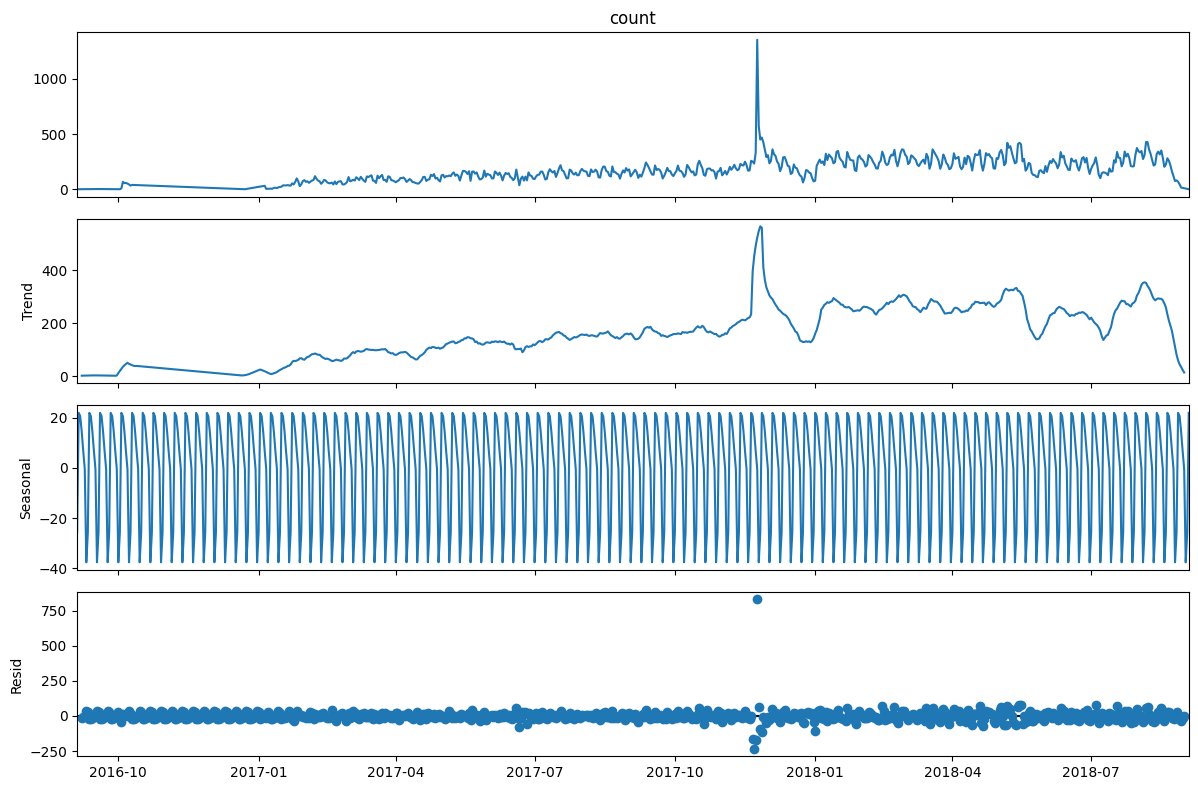

In [ ]:
# Additive seasonal decomposition - - dataset seems to have trend and seasonality
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df['count'], model='additive')
fig = decomposition.plot()
plt.show()

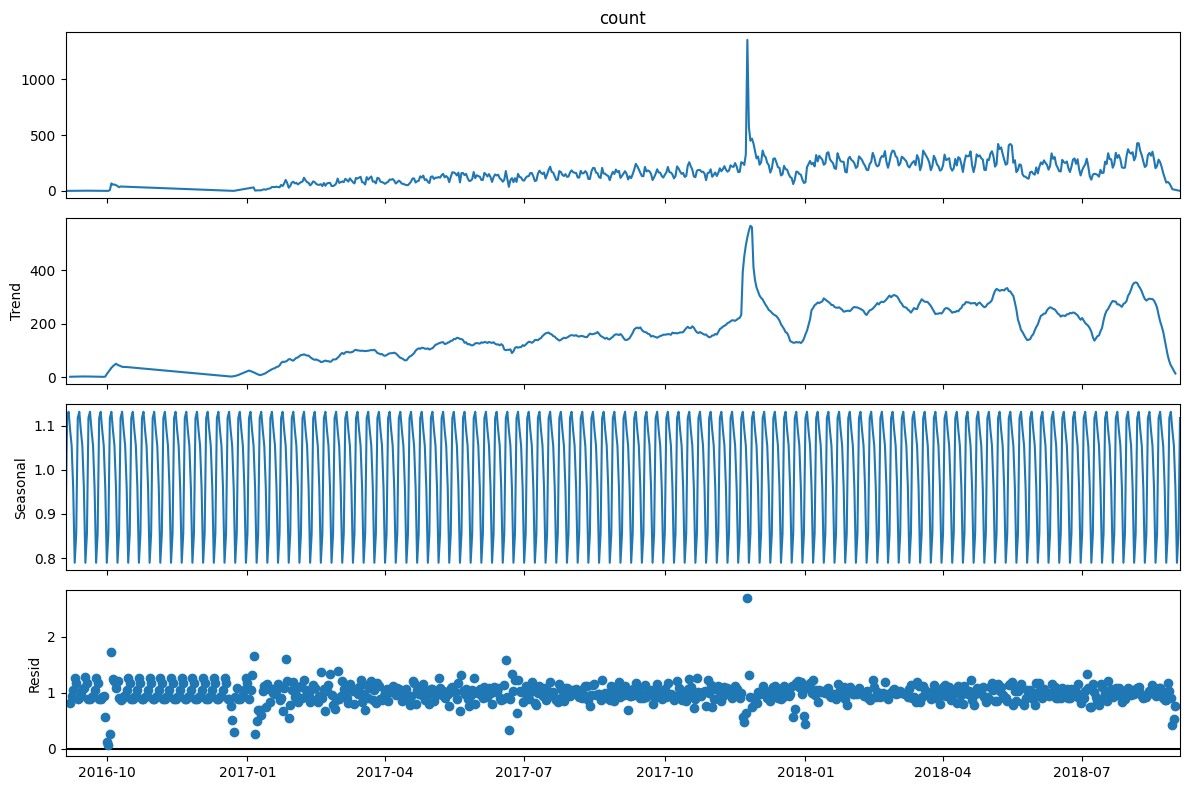

In [ ]:
# Multiplicative seasonal decomposition - dataset seems to have trend and seasonality
decomposition = sm.tsa.seasonal_decompose(df['count'], model='multiplicative')
fig = decomposition.plot()
plt.show()

# **Classical time series forecasting**

In [ ]:
# Train test split - 600 observations as train and 130 as test
train_len = 600
train = df[:train_len]
test = df[train_len:]
print(len(train))
print(len(test))

600
130




*  Various time series forecast models will be build and compared regarding RMSE and MAPE values.
*   Lower values of RMSE and MAPE are desired to conclude that a model performs better.

*   Accuracy is calculated as (100 - MAPE).
*   Lower the MAPE value, higher is the accuracy.




## **Naive method**

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['count'][train_len-1]

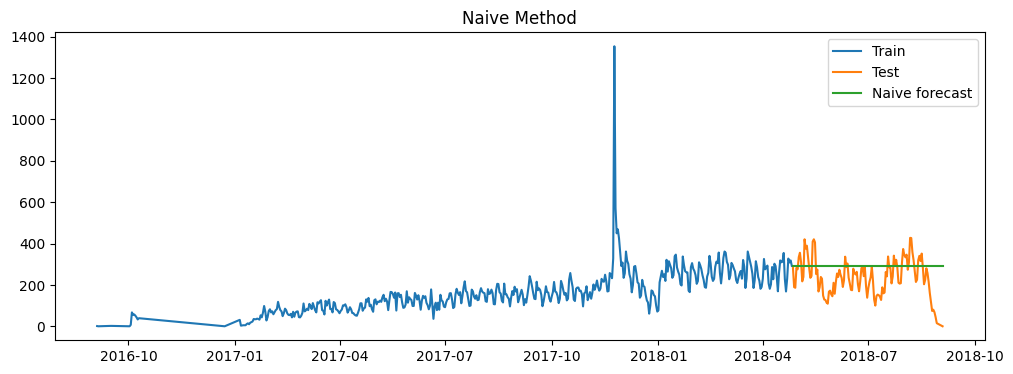

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_naive['naive_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_naive['naive_forecast']).round(2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [MAPE], 'RMSE': [RMSE]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.1


The forecast for a short-term period (14 days, ie. from 2018-09-10 till 2018-09-24) 7 days from the last date in the data for all products (2018-09-03) is 293 (the same as last observation from train set).

## **Simple average method**

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['count'].mean()
print(y_hat_avg['avg_forecast'][0])

137.74083333333334


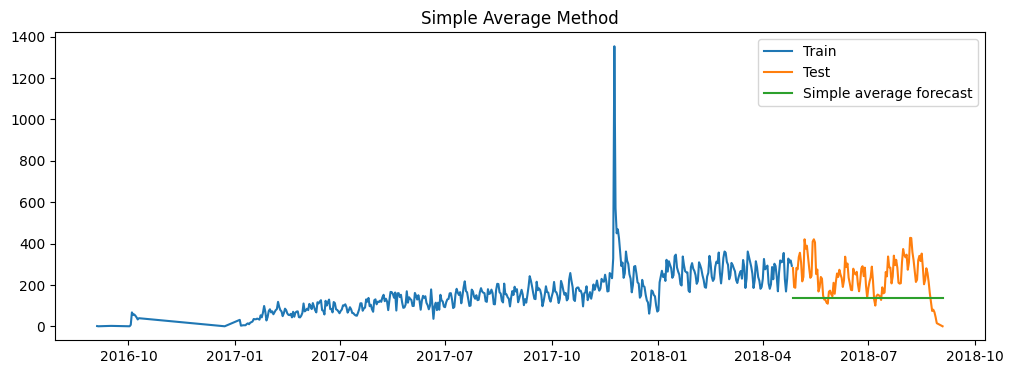

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_avg['avg_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_avg['avg_forecast']).round(2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09


The forecast for a short-term period (14 days, ie. from 2018-09-10 till 2018-09-24) 7 days from the last date in the data for all products (2018-09-03) is 137.

## **Simple moving average method**

In [ ]:
y_hat_sma = df.copy()
ma_window = 365
y_hat_sma['sma_forecast'] = df['count'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

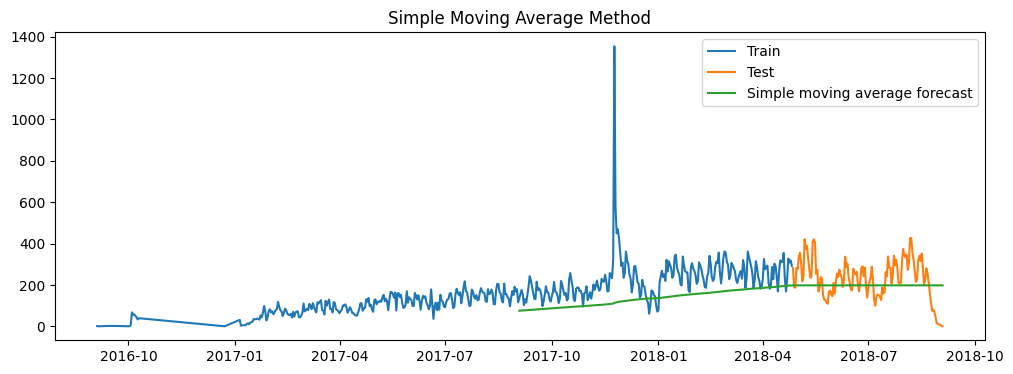

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_sma['sma_forecast'][train_len:])).round(2)
MAPE = np.round(np.mean(np.abs(test['count']-y_hat_sma['sma_forecast'][train_len:])/test['count']),2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77


## **Simple exponential smoothing**

In [ ]:
model = SimpleExpSmoothing(train['count'])
model_fit = model.fit(optimized=True)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))
print(model_fit.params)

{'smoothing_level': 0.36183715560540475, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 2.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


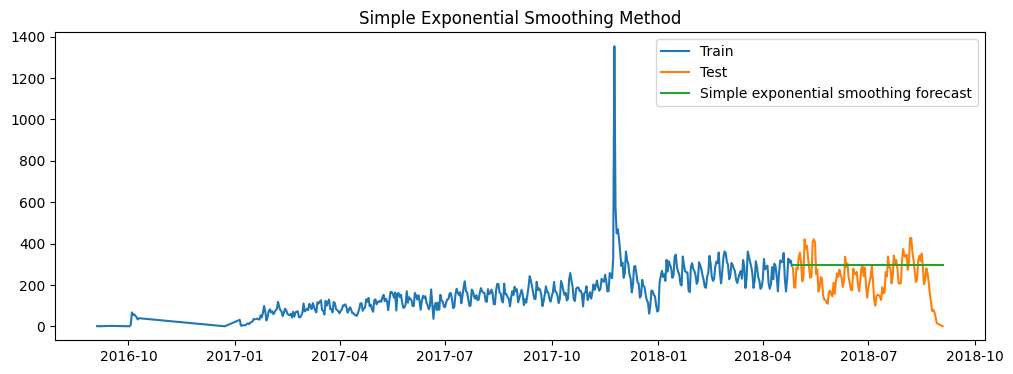

In [ ]:
# Plot train, test, forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_ses['ses_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_ses['ses_forecast']).round(2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15


In [ ]:
# Prediction for period
pred = model_fit.predict(start=(df.index.max() + timedelta(days=7)), end = (df.index.max() + timedelta(days=21)))
pred

2018-09-10    295.615013
2018-09-11    295.615013
2018-09-12    295.615013
2018-09-13    295.615013
2018-09-14    295.615013
2018-09-15    295.615013
2018-09-16    295.615013
2018-09-17    295.615013
2018-09-18    295.615013
2018-09-19    295.615013
2018-09-20    295.615013
2018-09-21    295.615013
2018-09-22    295.615013
2018-09-23    295.615013
2018-09-24    295.615013
Freq: D, dtype: float64

## **Holt's method with trend**

In [ ]:
model = ExponentialSmoothing(np.asarray(train['count']), seasonal_periods=365, trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.3586690967430486, 'smoothing_trend': 0.00014585628053106277, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1.0795972649424193, 'initial_trend': 0.49083964092547683, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


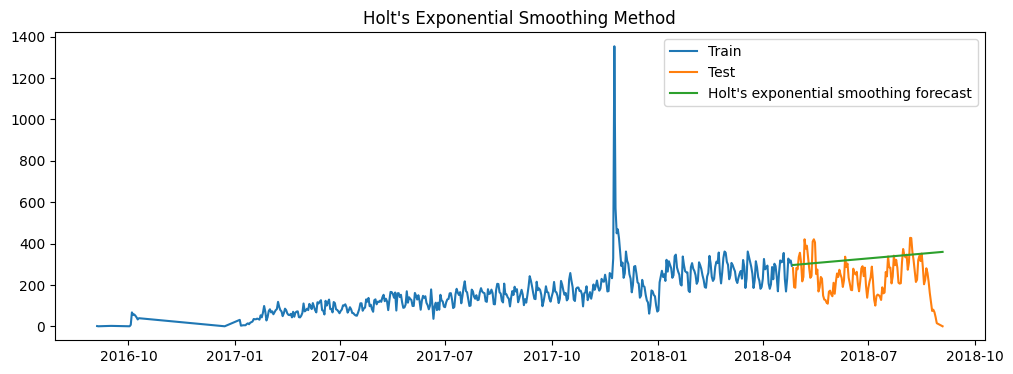

In [ ]:
# Plot train, test, forecast
plt.figure(figsize=(12,4))
plt.plot( train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_holt['holt_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_holt['holt_forecast']).round(2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07


In [ ]:
# Predictions for period
pred = model_fit.forecast(21)
datelist = pd.date_range(df.index.max() + timedelta(days=7), periods=14).tolist()
a = pd.DataFrame(pred[7:], datelist)
a

,0
2018-09-10,300.286044
2018-09-11,300.777128
2018-09-12,301.268212
2018-09-13,301.759296
2018-09-14,302.250380
2018-09-15,302.741464
2018-09-16,303.232548
2018-09-17,303.723632
2018-09-18,304.214716
2018-09-19,304.705800


Simple exponential smoothing method performs better than Holt's exponential smoothing method.

## **Holt Winters' additive method with trend and seasonability**

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['count']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.36083768700914776, 'smoothing_trend': 0.001226369216066831, 'smoothing_seasonal': 0.003181894471570377, 'damping_trend': nan, 'initial_level': 1.8800487974455546, 'initial_trend': 0.4396707565035163, 'initial_seasons': array([ 2.34694074,  6.039676  , 17.36438843,  0.08467404, -2.45377215,
        0.71670551, -3.72553324, -4.49827881, -5.37232802, -4.89637696,
       -2.23771256, -3.60097508]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


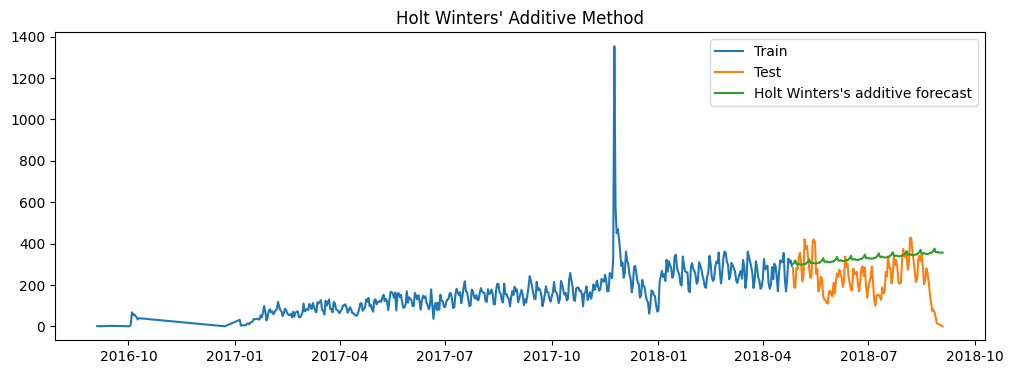

In [ ]:
# Plot train, test, forecast
plt.figure(figsize=(12,4))
plt.plot( train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_hwa['hw_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_hwa['hw_forecast']).round(2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05


In [ ]:
# Predictions for period
pred = model_fit.forecast(21)
datelist = pd.date_range(df.index.max() + timedelta(days=7), periods=14).tolist()
a = pd.DataFrame(pred[7:], datelist)
a

,0
2018-09-10,299.029511
2018-09-11,298.690132
2018-09-12,299.662079
2018-09-13,302.770192
2018-09-14,301.965148
2018-09-15,308.366329
2018-09-16,312.571160
2018-09-17,324.410620
2018-09-18,307.593000
2018-09-19,305.463763


Holt Winters' additive method performs worse than Holt's method with trend.

## **Holt Winters' multiplicative method with trend and seasonality**

In [ ]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['count']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.35894207841471004, 'smoothing_trend': 0.0001313630235933997, 'smoothing_seasonal': 0.0835904987189702, 'damping_trend': nan, 'initial_level': 2.1103316003097996, 'initial_trend': 0.13460521910303536, 'initial_seasons': array([3.21681328, 3.45605006, 4.23049796, 1.01954439, 1.78540562,
       0.92583263, 1.38475915, 2.6533459 , 2.16689501, 1.79192842,
       2.14829919, 2.40563263]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


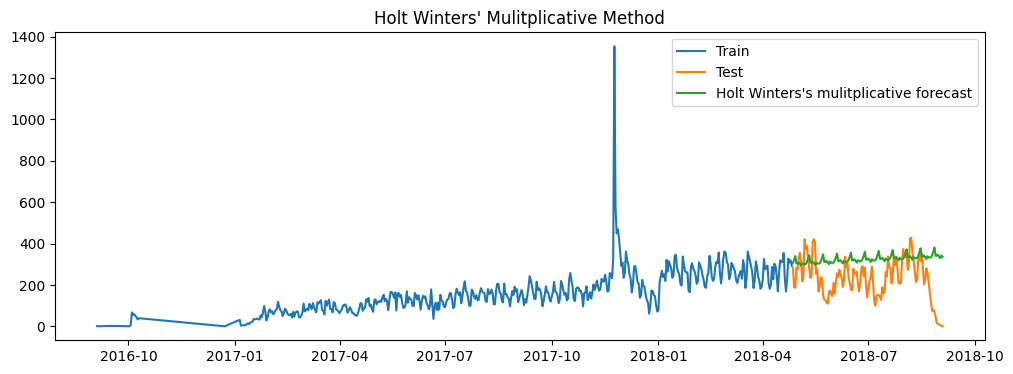

In [ ]:
# Plot train, test, forecast
plt.figure(figsize=(12,4))
plt.plot( train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_hwm['hw_forecast'])).round(2)
MAPE = mape(test['count'], y_hat_hwm['hw_forecast']).round(2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79


In [ ]:
# Predictions for period
pred = model_fit.forecast(21)
datelist = pd.date_range(df.index.max() + timedelta(days=7), periods=14).tolist()
a = pd.DataFrame(pred[7:], datelist)
a

,0
2018-09-10,293.646997
2018-09-11,305.983303
2018-09-12,300.482509
2018-09-13,300.034504
2018-09-14,301.073926
2018-09-15,311.128795
2018-09-16,325.719697
2018-09-17,344.007287
2018-09-18,308.222123
2018-09-19,307.912755


Holt Winters' multiplicative method performs better than Holt Winters' additive method.




*   Simple exponential smoothing method is the best among smoothing techniques.
*   It is able to forecast closer to the actual values.
*   The RMSE and MAPE values for this method are lower as compared to other model methods.
*   This method is able to capture the trend and seasonality in the data.





## **Augmented Dickey-Fuller (ADF) test**

In [ ]:
adf_test = adfuller(df['count'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -2.539128
Critical Values @ 0.05: -2.87
p-value: 0.106242


p-value is more than 0.05. This means that the series is not stationary.

## **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**

In [ ]:
kpss_test = kpss(df['count'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 3.414336
Critical Values @ 0.05: 0.46
p-value: 0.010000


p-value is less than 0.05. This means that the series is not stationary.

To make the series stationary, we need to perform transformation and differencing.

## **Box Cox transformation to make variance constant**

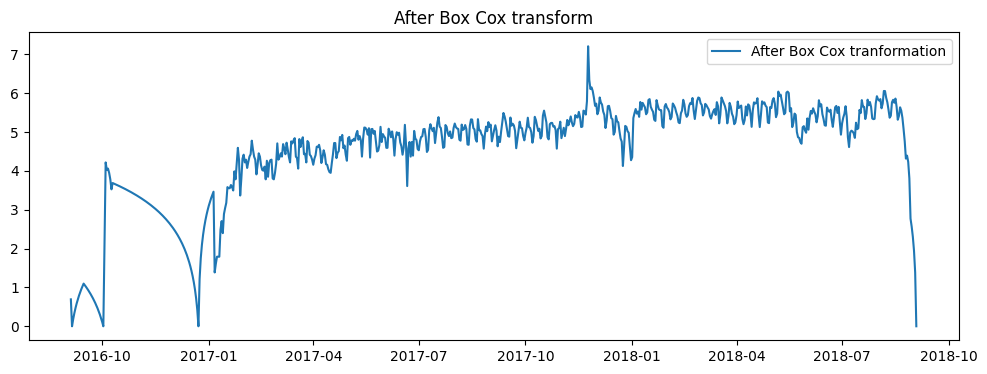

In [ ]:
data_boxcox = pd.Series(boxcox(df['count'], lmbda=0), index = df.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

## **Differencing to remove trend**

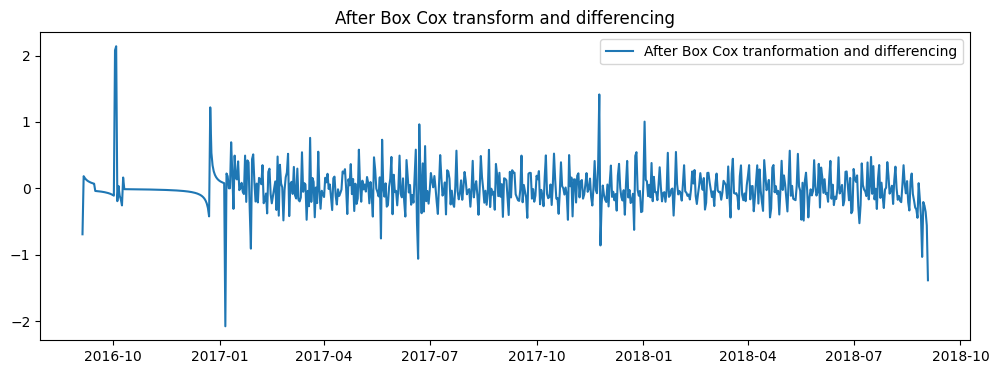

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.dropna(inplace=True)

We will check whether our series has become stationary.

## **Augmented Dickey-Fuller (ADF) test**

In [ ]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.335089
Critical Values @ 0.05: -2.87
p-value: 0.013381


p-value is less than 0.05. This means that the series is stationary.

## **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**

In [ ]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.430290
Critical Values @ 0.05: 0.46
p-value: 0.064099


p-value is more than 0.05. This means that the series is stationary.

## **Train-test split**

In [ ]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## **Auto regression model (AR)**

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.params)

const     0.008319
ar.L1     0.005894
sigma2    0.085065
dtype: float64


In [ ]:
# Recover original time series
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

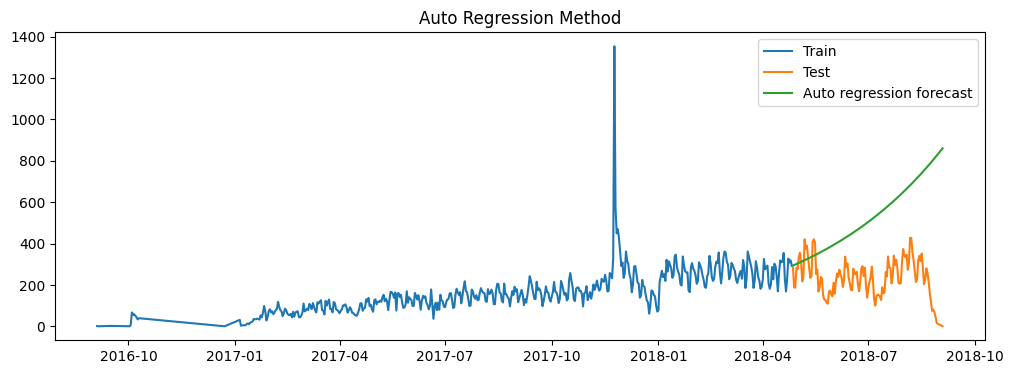

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
MAPE = mape(test['count'], y_hat_ar['ar_forecast'][test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19


In [ ]:
# Prediction for period
pred = model_fit.predict(start=(df.index.max() + timedelta(days=7)), end = (df.index.max() + timedelta(days=21)))
pred

2018-09-10    0.008319
2018-09-11    0.008319
2018-09-12    0.008319
2018-09-13    0.008319
2018-09-14    0.008319
2018-09-15    0.008319
2018-09-16    0.008319
2018-09-17    0.008319
2018-09-18    0.008319
2018-09-19    0.008319
2018-09-20    0.008319
2018-09-21    0.008319
2018-09-22    0.008319
2018-09-23    0.008319
2018-09-24    0.008319
Freq: D, Name: predicted_mean, dtype: float64

AR method works worse than Holt Winters' multiplicative method and Holt Winters' additive method.

## **Moving average method (MA)**

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.008308
ma.L1     0.009274
sigma2    0.085061
dtype: float64


In [ ]:
# Recover original time series
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

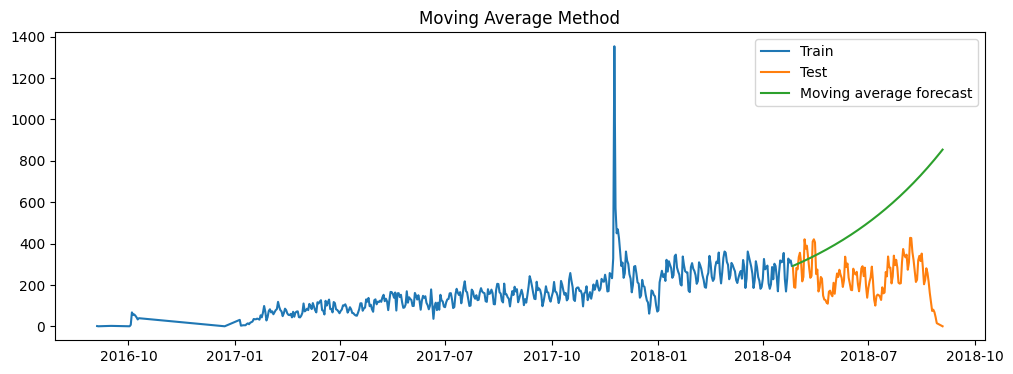

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(df['count'][:train_len], label='Train')
plt.plot(df['count'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
MAPE = mape(test['count'], y_hat_ma['ma_forecast'][test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10


In [ ]:
# Prediction for period
pred = model_fit.predict(start=(df.index.max() + timedelta(days=7)), end = (df.index.max() + timedelta(days=21)))
pred

2018-09-10    0.008308
2018-09-11    0.008308
2018-09-12    0.008308
2018-09-13    0.008308
2018-09-14    0.008308
2018-09-15    0.008308
2018-09-16    0.008308
2018-09-17    0.008308
2018-09-18    0.008308
2018-09-19    0.008308
2018-09-20    0.008308
2018-09-21    0.008308
2018-09-22    0.008308
2018-09-23    0.008308
2018-09-24    0.008308
Freq: D, Name: predicted_mean, dtype: float64

MA method works better as compared to AR method.

## **Auto regression moving average method (ARMA)**

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.008355
ar.L1     0.780727
ma.L1    -0.896093
sigma2    0.082239
dtype: float64


In [ ]:
# Recover original time series
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

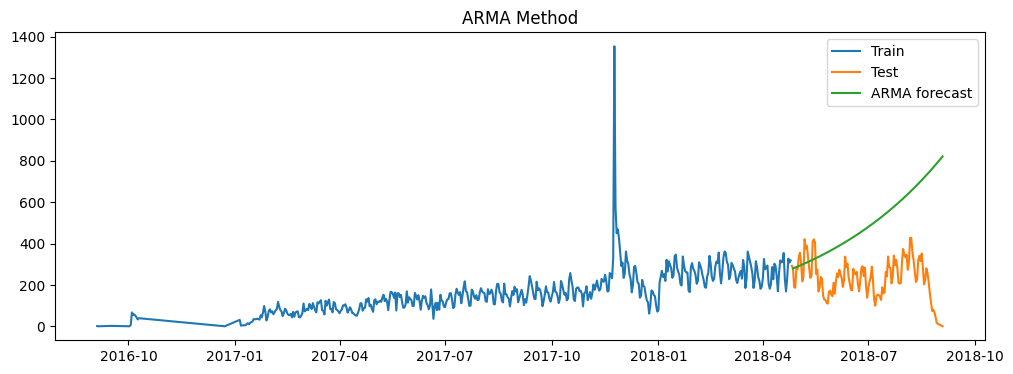

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(df['count'][:train_len-1], label='Train')
plt.plot(df['count'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
MAPE = mape(test['count'],y_hat_arma['arma_forecast'][train_len-1:]).round(2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
pred = model_fit.predict(start=(df.index.max() + timedelta(days=7)), end = (df.index.max() + timedelta(days=21)))
pred

2018-09-10    0.008355
2018-09-11    0.008355
2018-09-12    0.008355
2018-09-13    0.008355
2018-09-14    0.008355
2018-09-15    0.008355
2018-09-16    0.008355
2018-09-17    0.008355
2018-09-18    0.008355
2018-09-19    0.008355
2018-09-20    0.008355
2018-09-21    0.008355
2018-09-22    0.008355
2018-09-23    0.008355
2018-09-24    0.008355
Freq: D, Name: predicted_mean, dtype: float64

ARMA method performs better than MA method and AR method.

## **Seasonal auto regressive integrated moving average (SARIMA)**

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.605099
ma.L1       0.663472
ar.S.L12   -0.127476
ma.S.L12   -0.950444
sigma2      0.085698
dtype: float64


In [ ]:
# Recover original time series forecast
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

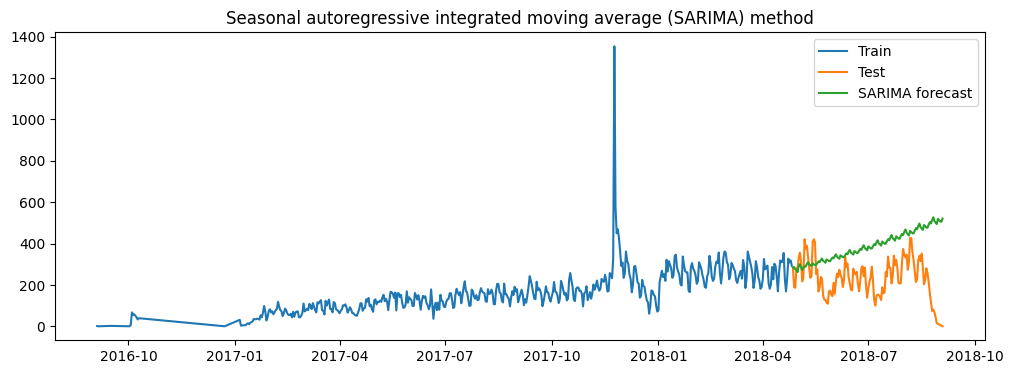

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(test['count'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
MAPE = mape(test['count'], y_hat_sarima['sarima_forecast'][test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
pred = model_fit.predict(start=(df.index.max() + timedelta(days=7)), end = (df.index.max() + timedelta(days=21)))
pred

2018-09-10    6.263020
2018-09-11    6.312546
2018-09-12    6.299225
2018-09-13    6.286928
2018-09-14    6.285303
2018-09-15    6.314968
2018-09-16    6.339683
2018-09-17    6.327720
2018-09-18    6.361949
2018-09-19    6.385703
2018-09-20    6.350438
2018-09-21    6.337388
2018-09-22    6.322148
2018-09-23    6.371674
2018-09-24    6.358353
Freq: D, Name: predicted_mean, dtype: float64

SARIMA method performs better than ARMA model.

Conclusion : The interpretation of actual models built for forecasting amount of purchases of the time series data show that:

1. Simple average method.

2. Simple moving average technique.

are the best for forecasting the amount of purchases for the data.

Both the methods have lower RMSE and MAPE values and are able to capture the trend and seasonality components well in the data.

# **Machine learning time series forecasting**

## **Linear Regression**

In [ ]:
# Train test split
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(600, 130)

In [ ]:
lr_train = train.copy()
lr_test = test.copy()
lr_train['time'] = train_time
lr_test['time'] = test_time
model = LinearRegression()
model.fit(lr_train[['time']], lr_train['count'].values)
pred = model.predict(lr_test[['time']])
lr_test['forecast'] = pred

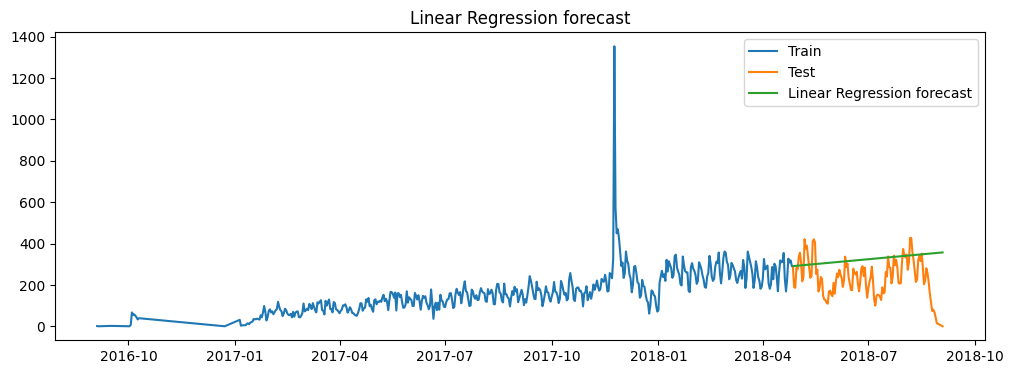

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(lr_train['count'], label='Train')
plt.plot(lr_test['count'], label='Test')
plt.plot(lr_test['forecast'], label='Linear Regression forecast')
plt.legend(loc='best')
plt.title('Linear Regression forecast')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(lr_test['count'], lr_test['forecast'][lr_test.index.min():])).round(2)
MAPE = mape(lr_test['count'], lr_test['forecast'][lr_test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Linear Regression method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
datelist = pd.date_range(lr_test.index.max() + timedelta(days=7), periods=14).tolist()
t = list(range(lr_test['time'].max()+7, lr_test['time'].max()+21))
a = pd.DataFrame(t, datelist)
a.columns = [['time']]
pred = model.predict(a)
pred

array([361.15883188, 361.67067151, 362.18251114, 362.69435077,
       363.2061904 , 363.71803003, 364.22986966, 364.74170929,
       365.25354892, 365.76538855, 366.27722818, 366.78906781,
       367.30090744, 367.81274707])

## **XGB Regression**

In [ ]:
# Train test split
r_train = train.copy()
r_test = test.copy()
r_train['time'] = train_time
r_test['time'] = test_time
model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(r_train[['time']], r_train['count'].values)
pred = model.predict(r_test[['time']])
r_test['forecast'] = pred

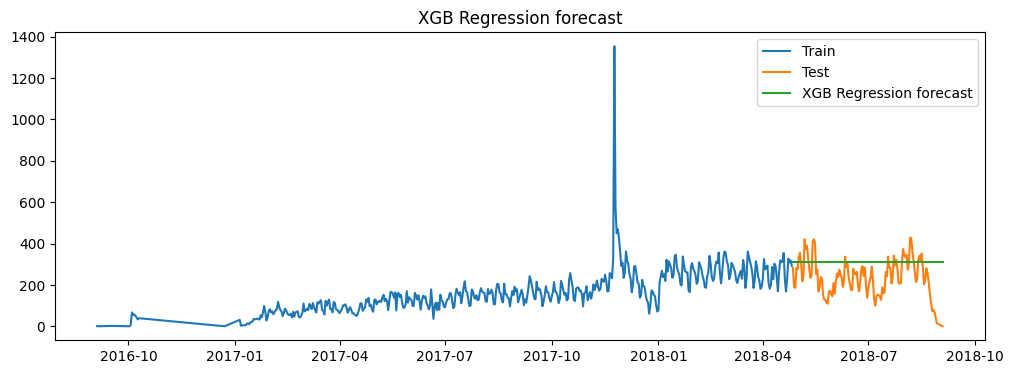

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(r_train['count'], label='Train')
plt.plot(r_test['count'], label='Test')
plt.plot(r_test['forecast'], label='XGB Regression forecast')
plt.legend(loc='best')
plt.title('XGB Regression forecast')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(r_test['count'], r_test['forecast'][r_test.index.min():])).round(2)
MAPE = mape(r_test['count'], r_test['forecast'][r_test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['XGB Regression method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
datelist = pd.date_range(r_test.index.max() + timedelta(days=7), periods=14).tolist()
t = list(range(r_test['time'].max()+7, r_test['time'].max()+21))
a = pd.DataFrame(t, datelist)
a.columns = [['time']]
pred = model.predict(a)
pred

array([312.0998, 312.0998, 312.0998, 312.0998, 312.0998, 312.0998,
       312.0998, 312.0998, 312.0998, 312.0998, 312.0998, 312.0998,
       312.0998, 312.0998], dtype=float32)

## **Random Forest Regression**

In [ ]:
# Train test split
forest_train = train.copy()
forest_test = test.copy()
forest_train['time'] = train_time
forest_test['time'] = test_time
model = RandomForestRegressor()
model.fit(forest_train[['time']], forest_train['count'].values)
pred = model.predict(forest_test[['time']])
forest_test['forecast'] = pred

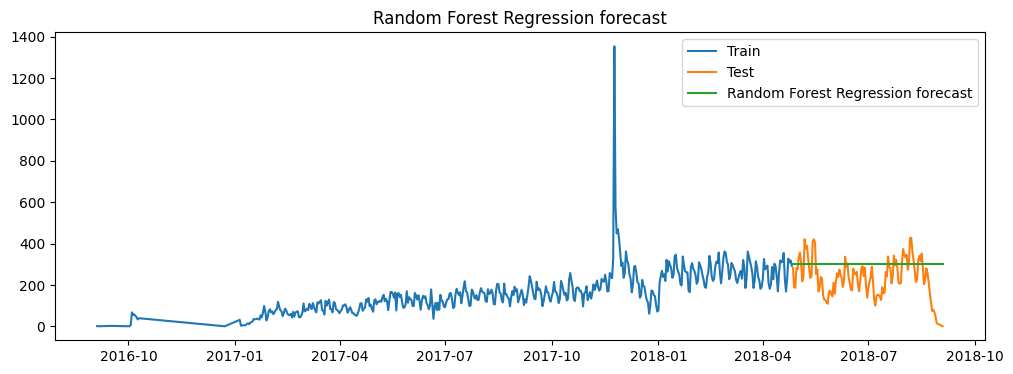

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(forest_train['count'], label='Train')
plt.plot(forest_test['count'], label='Test')
plt.plot(forest_test['forecast'], label='Random Forest Regression forecast')
plt.legend(loc='best')
plt.title('Random Forest Regression forecast')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(forest_test['count'], forest_test['forecast'][forest_test.index.min():])).round(2)
MAPE = mape(forest_test['count'], forest_test['forecast'][forest_test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Random Forest Regression method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
datelist = pd.date_range(forest_test.index.max() + timedelta(days=7), periods=14).tolist()
t = list(range(forest_test['time'].max()+7, forest_test['time'].max()+21))
a = pd.DataFrame(t, datelist)
a.columns = [['time']]
pred = model.predict(a)
pred

array([300.78, 300.78, 300.78, 300.78, 300.78, 300.78, 300.78, 300.78,
       300.78, 300.78, 300.78, 300.78, 300.78, 300.78])

## **Decision Tree Regression**

In [ ]:
# Train test split
tree_train = train.copy()
tree_test = test.copy()
tree_train['time'] = train_time
tree_test['time'] = test_time
model = ExtraTreeRegressor()
model.fit(tree_train[['time']], tree_train['count'].values)
pred = model.predict(tree_test[['time']])
tree_test['forecast'] = pred

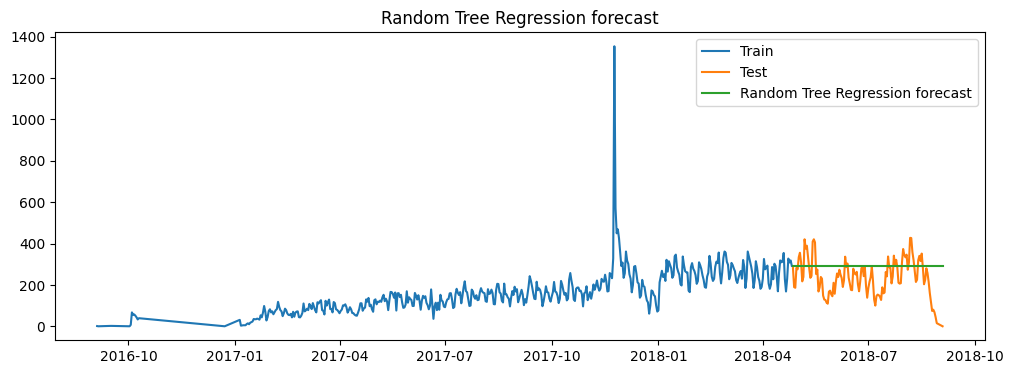

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(tree_train['count'], label='Train')
plt.plot(tree_test['count'], label='Test')
plt.plot(tree_test['forecast'], label='Random Tree Regression forecast')
plt.legend(loc='best')
plt.title('Random Tree Regression forecast')
plt.show()

In [ ]:
# Calculate RMSE and MAPE
RMSE = np.sqrt(mse(tree_test['count'], tree_test['forecast'][tree_test.index.min():])).round(2)
MAPE = mape(tree_test['count'], tree_test['forecast'][tree_test.index.min():]).round(2)

tempResults = pd.DataFrame({'Method':['Extra Tree Regression method'], 'RMSE': [RMSE],'MAPE': [MAPE] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,112.57,4.10
0,Simple average method,133.52,2.09
0,Simple moving average forecast,100.29,2.77
0,Simple exponential smoothing forecast,114.01,4.15
0,Holt's exponential smoothing method,139.57,5.07
0,Holt Winters' additive method,141.33,5.05
0,Holt Winters' multiplicative method,136.72,4.79
0,Autoregressive (AR) method,362.79,12.19
0,Moving Average (MA) method,359.14,12.10
0,Autoregressive moving average (ARMA) method,338.74,11.59


In [ ]:
# Prediction for period
datelist = pd.date_range(tree_test.index.max() + timedelta(days=7), periods=14).tolist()
t = list(range(tree_test['time'].max()+7, tree_test['time'].max()+21))
a = pd.DataFrame(t, datelist)
a.columns = [['time']]
pred = model.predict(a)
pred

array([293., 293., 293., 293., 293., 293., 293., 293., 293., 293., 293.,
       293., 293., 293.])

# **Summary**

*   Among simplest methods, the best performance has been achieved by Simple moving average method.
*   Among smoothing methods, the best performance has been achieved by Simple exponential smoothing method.
*   Among regressive methods, the best performance has been achieved by Holt Winters' multiplicative method. The more complex was the technique, the weaker results it has achieved.
*   Among machine learning methods, the best performance has been achieved by Extra tree regression method.
* Not all machine learning methods have been considered.
* Undoubtedly, the parameter tuning for currently used models will cause improvement in performance.
* To sum up, one of machine learning models should be considered as target one due to low RMSE and MAPE values. Moreover, they are able to capture trend and seasonability in the data.



